# Кластеризация абонентов сотового оператора

**Цель:** сегментация пользователей по интересам (интернет-трафик) для формирования персонализированных предложений.

**Методика:**
1. Загрузка и валидация данных (activity, clients, websites, categories, regions)
2. Построение матрицы признаков: для каждого абонента — вектор числа посещений по категориям сайтов
3. Нормализация признаков (StandardScaler)
4. Подбор оптимального числа кластеров (Elbow + Silhouette)
5. Кластеризация методом K-Means
6. Визуализация кластеров (PCA) и демографический анализ

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

DATA = 'sber_data/'
activity = pd.read_csv(DATA + 'activity.csv', sep=';')
clients = pd.read_csv(DATA + 'clients.csv', sep=';')
categories = pd.read_csv(DATA + 'categories.csv', sep=';')
websites = pd.read_csv(DATA + 'websites.csv', sep=';')
regions = pd.read_csv(DATA + 'regions.csv', sep=';')

print(f"activity: {activity.shape}, clients: {clients.shape}")
print(f"categories: {categories.shape}, websites: {websites.shape}, regions: {regions.shape}")

activity: (1200000, 2), clients: (50000, 4)
categories: (30, 2), websites: (1251, 2), regions: (23, 2)


## Валидация данных

In [54]:
for name, df in [('activity', activity), ('clients', clients), ('categories', categories), ('websites', websites), ('regions', regions)]:
    print(f"\n=== {name} ===")
    print(f"Размер: {df.shape}, Дубликаты: {df.duplicated().sum()}")
    print(f"Пропуски:\n{df.isnull().sum()}")

print("\n=== Статистика clients ===")
print(clients.describe())
print(f"\nПол: {clients['gender'].value_counts().to_dict()}")
print(f"Возраст: {clients['age'].min()}-{clients['age'].max()}")


=== activity ===
Размер: (1200000, 2), Дубликаты: 90676
Пропуски:
client_id    0
website      0
dtype: int64

=== clients ===
Размер: (50000, 4), Дубликаты: 0
Пропуски:
id            0
age           0
gender       82
region_id     0
dtype: int64

=== categories ===
Размер: (30, 2), Дубликаты: 0
Пропуски:
id      0
name    0
dtype: int64

=== websites ===
Размер: (1251, 2), Дубликаты: 0
Пропуски:
website        0
category_id    0
dtype: int64

=== regions ===
Размер: (23, 2), Дубликаты: 0
Пропуски:
id      0
name    0
dtype: int64

=== Статистика clients ===
                age     region_id
count  50000.000000  50000.000000
mean      35.289600     11.269820
std       11.414935      6.386413
min       16.000000      1.000000
25%       27.000000      6.000000
50%       35.000000     12.000000
75%       43.000000     17.000000
max       80.000000     23.000000

Пол: {'F': 25997, 'M': 23921}
Возраст: 16-80


## Построение матрицы признаков

In [55]:
merged = activity.merge(websites, on='website', how='left')
merged = merged.merge(categories, left_on='category_id', right_on='id', how='left', suffixes=('', '_cat'))
merged = merged.dropna(subset=['name'])

pivot = merged.groupby(['client_id', 'name']).size().unstack(fill_value=0)
pivot.columns.name = None

# Нормализуем строки: делим каждую на сумму по строке.
# Без этого KMeans разделит пользователей по объёму активности
# (активные vs неактивные), а не по профилю интересов.
# После нормализации каждая строка — распределение долей посещений
# по категориям, и кластеризация идёт именно по паттерну интересов.
pivot = pivot.div(pivot.sum(axis=1), axis=0)

print(f"Матрица признаков: {pivot.shape}")
pivot.head()

Матрица признаков: (42796, 29)


,Авто и мото,Аксессуары,Детские товары,Дом и сад,Игры,Каршеринг и такси,Кафе и рестораны,Книги и канцелярия,Красота и здоровье,Маркетплейсы,...,Питомцы,Продукты питания,Путешествия и билеты,Развлечения,Социальные сети,Спорт и активный отдых,Стройка и ремонт,Финансы и страхование,Фитнес,Ювелирные изделия
client_id,,,,,,,,,,,,,,,,,,,,,
00022434-3f6f-44f1-bed3-f161e6da50ba,0.020833,0.062500,0.041667,0.0,0.020833,0.062500,0.0,0.020833,0.083333,0.041667,...,0.000000,0.020833,0.041667,0.020833,0.041667,0.104167,0.062500,0.020833,0.020833,0.062500
0006bab8-0c5e-464c-830f-9824e345cb68,0.000000,0.222222,0.000000,0.0,0.000000,0.111111,0.0,0.000000,0.000000,0.000000,...,0.111111,0.000000,0.111111,0.000000,0.000000,0.222222,0.000000,0.000000,0.000000,0.111111
00071f19-98ed-4d34-919a-59256b5b12b2,0.058824,0.058824,0.058824,0.0,0.058824,0.058824,0.0,0.000000,0.000000,0.117647,...,0.000000,0.000000,0.058824,0.058824,0.000000,0.176471,0.000000,0.000000,0.000000,0.058824
000ef69d-7bf7-49a2-b759-9216006c5481,0.000000,0.100000,0.050000,0.0,0.050000,0.050000,0.0,0.050000,0.050000,0.000000,...,0.050000,0.050000,0.150000,0.000000,0.000000,0.100000,0.050000,0.000000,0.000000,0.100000
000f5378-e619-4ef8-b9d8-2c06079e2f42,0.000000,0.096774,0.032258,0.0,0.064516,0.064516,0.0,0.000000,0.000000,0.064516,...,0.000000,0.032258,0.032258,0.000000,0.064516,0.129032,0.096774,0.032258,0.000000,0.096774


In [56]:
scaler = StandardScaler()
X = scaler.fit_transform(pivot)

## Подбор числа кластеров

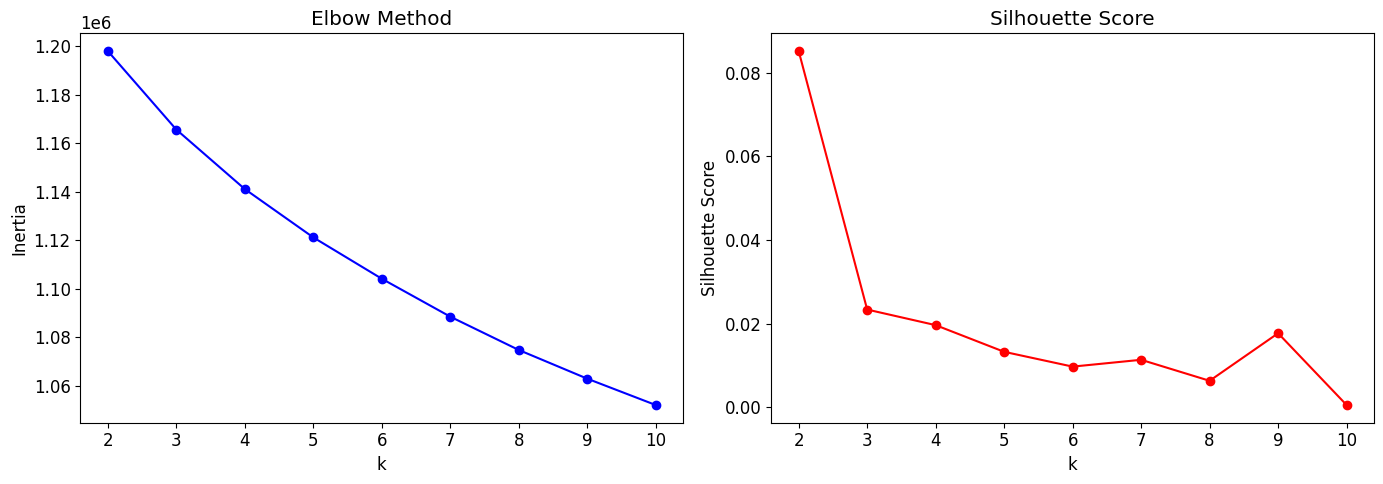

Лучший k по silhouette: 2 (score=0.0852)


In [57]:
K_range = range(2, 11)
inertias, sil_scores = [], []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels, sample_size=5000, random_state=42))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax2.plot(K_range, sil_scores, 'ro-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')
plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(sil_scores)]
print(f"Лучший k по silhouette: {best_k} (score={max(sil_scores):.4f})")

## Кластеризация K-Means

In [58]:
kmeans = KMeans(n_clusters=best_k, n_init=10)
pivot['cluster'] = kmeans.fit_predict(X)
print(pivot['cluster'].value_counts().sort_index())

cluster
0    13193
1    29603
Name: count, dtype: int64


## PCA-визуализация кластеров

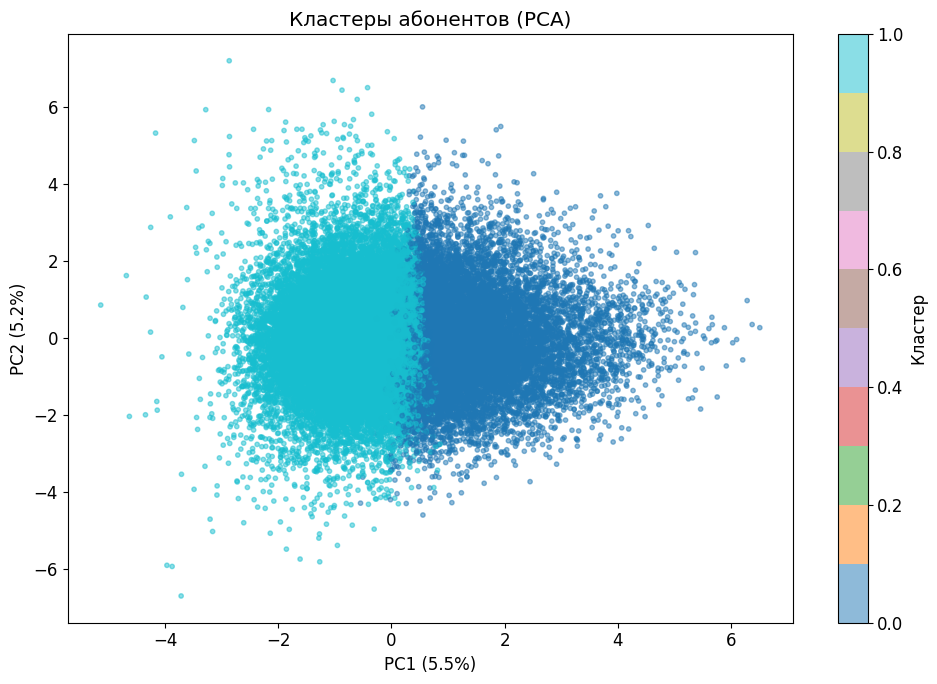

In [59]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pivot['cluster'], cmap='tab10', alpha=0.5, s=10)
plt.colorbar(scatter, label='Кластер')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('Кластеры абонентов (PCA)')
plt.tight_layout()
plt.show()

## Профили кластеров по интересам

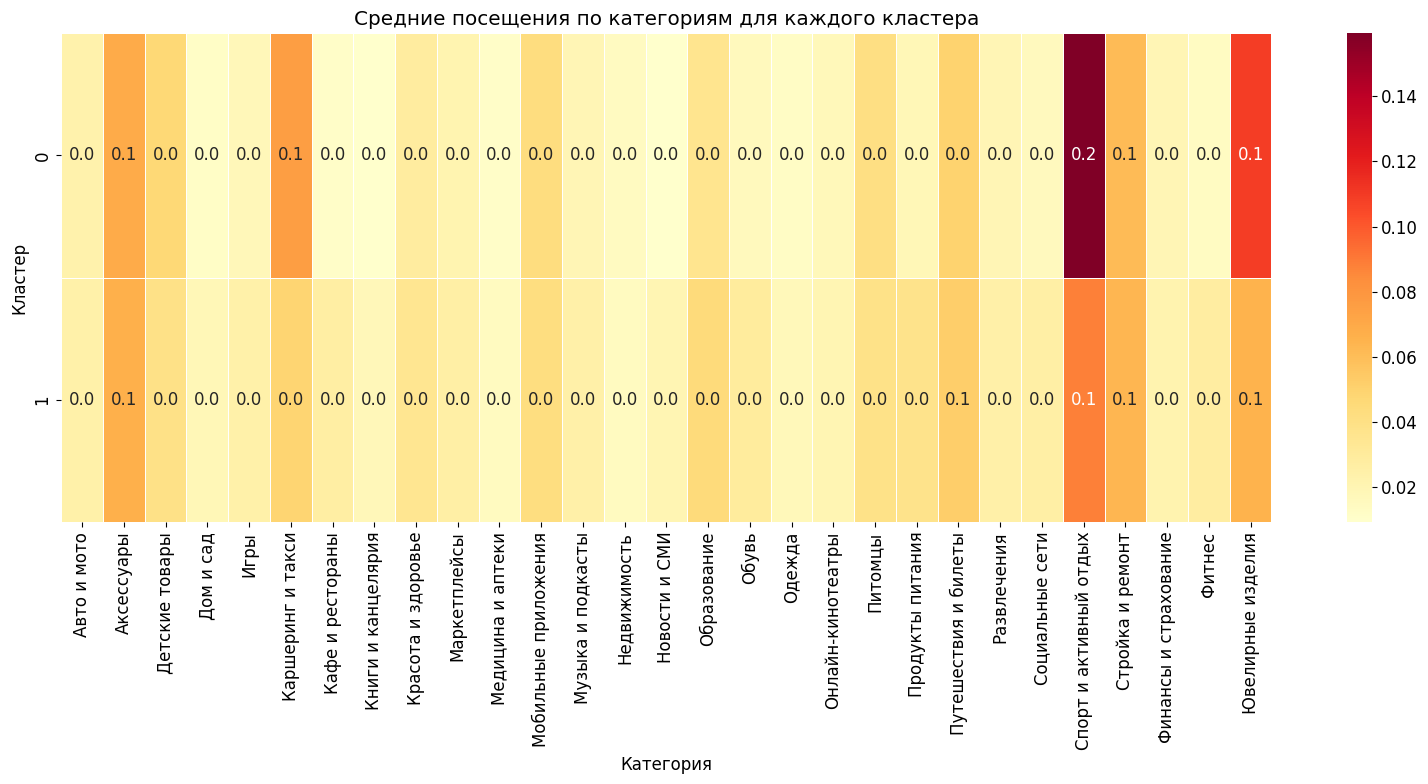

In [60]:
cat_cols = [c for c in pivot.columns if c != 'cluster']
cluster_profiles = pivot.groupby('cluster')[cat_cols].mean()

plt.figure(figsize=(16, 8))
sns.heatmap(cluster_profiles, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5)
plt.title('Средние посещения по категориям для каждого кластера')
plt.xlabel('Категория')
plt.ylabel('Кластер')
plt.tight_layout()
plt.show()

In [61]:
for cl in sorted(pivot['cluster'].unique()):
    top = cluster_profiles.loc[cl].nlargest(5)
    print(f"\nКластер {cl} ({(pivot['cluster']==cl).sum()} абонентов):")
    print(f"  Топ-5 категорий: {', '.join(top.index)}")


Кластер 0 (13193 абонентов):
  Топ-5 категорий: Спорт и активный отдых, Ювелирные изделия, Каршеринг и такси, Аксессуары, Стройка и ремонт

Кластер 1 (29603 абонентов):
  Топ-5 категорий: Спорт и активный отдых, Аксессуары, Ювелирные изделия, Стройка и ремонт, Путешествия и билеты


## Демографический анализ кластеров

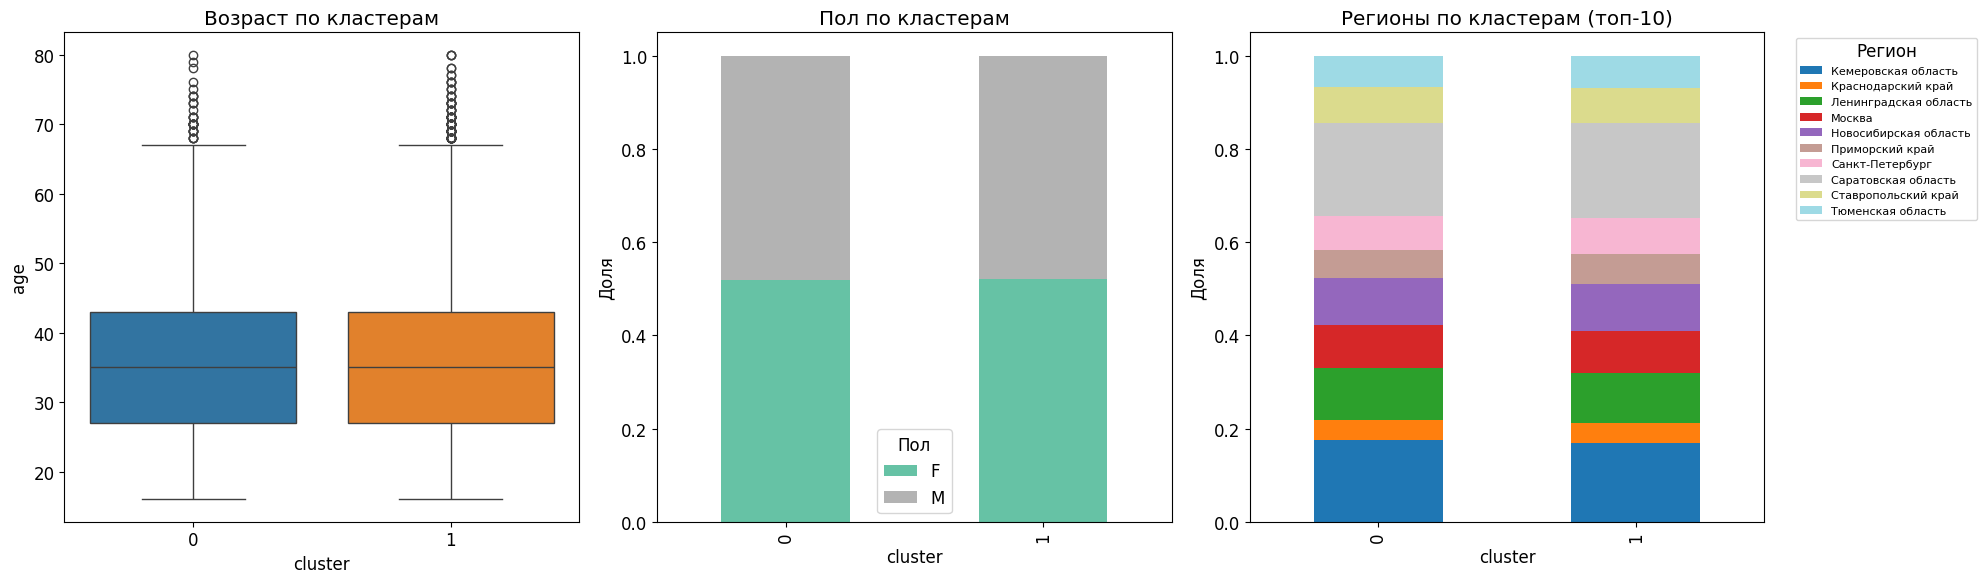

In [62]:
df = pivot[['cluster']].reset_index().merge(clients, left_on='client_id', right_on='id', how='left')
df = df.merge(regions, left_on='region_id', right_on='id', how='left', suffixes=('', '_reg'))
df.rename(columns={'name': 'region_name'}, inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.boxplot(data=df, x='cluster', y='age', ax=axes[0], palette='tab10')
axes[0].set_title('Возраст по кластерам')

gender_ct = pd.crosstab(df['cluster'], df['gender'], normalize='index')
gender_ct.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set2')
axes[1].set_title('Пол по кластерам')
axes[1].set_ylabel('Доля')
axes[1].legend(title='Пол')

top_regions = df['region_name'].value_counts().head(10).index
region_ct = pd.crosstab(df[df['region_name'].isin(top_regions)]['cluster'], df[df['region_name'].isin(top_regions)]['region_name'], normalize='index')
region_ct.plot(kind='bar', stacked=True, ax=axes[2], colormap='tab20')
axes[2].set_title('Регионы по кластерам (топ-10)')
axes[2].set_ylabel('Доля')
axes[2].legend(title='Регион', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [63]:
for cl in sorted(df['cluster'].unique()):
    sub = df[df['cluster'] == cl]
    print(f"\nКластер {cl} ({len(sub)} чел.):")
    print(f"  Возраст: {sub['age'].mean():.1f} ± {sub['age'].std():.1f}")
    print(f"  Пол: {sub['gender'].value_counts(normalize=True).to_dict()}")
    print(f"  Топ-3 региона: {', '.join(sub['region_name'].value_counts().head(3).index)}")


Кластер 0 (13193 чел.):
  Возраст: 35.3 ± 11.5
  Пол: {'F': 0.5187238890998861, 'M': 0.48127611090011396}
  Топ-3 региона: Саратовская область, Кемеровская область, Ленинградская область

Кластер 1 (29603 чел.):
  Возраст: 35.3 ± 11.4
  Пол: {'F': 0.5215346618398349, 'M': 0.4784653381601651}
  Топ-3 региона: Саратовская область, Кемеровская область, Ленинградская область


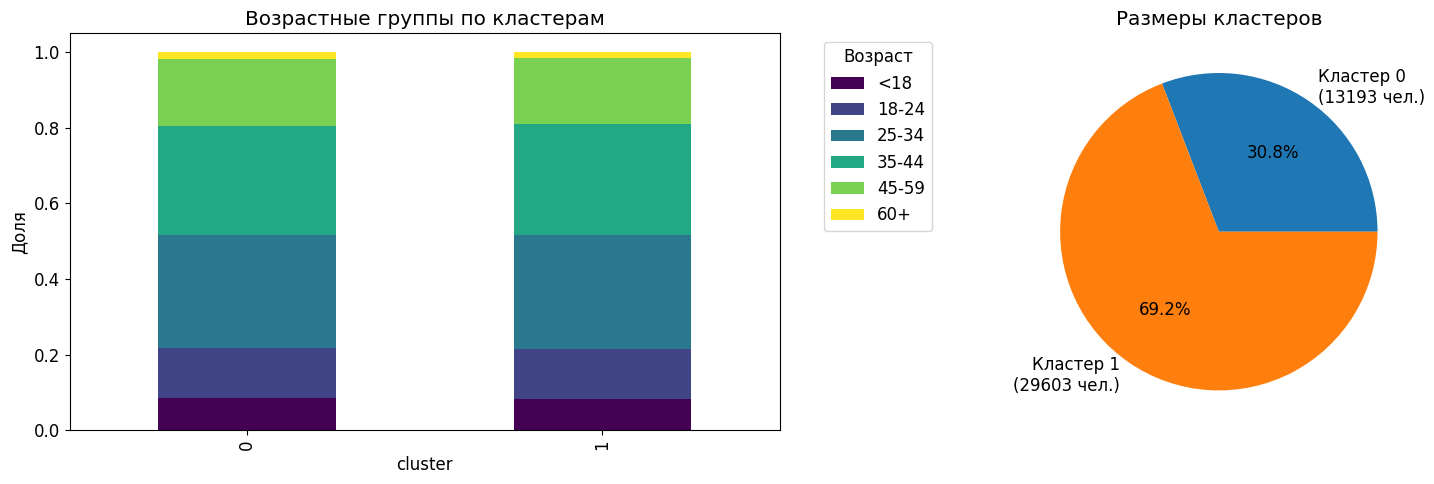

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

age_bins = [0, 18, 25, 35, 45, 60, 100]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-59', '60+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)
age_ct = pd.crosstab(df['cluster'], df['age_group'], normalize='index')
age_ct.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis')
axes[0].set_title('Возрастные группы по кластерам')
axes[0].set_ylabel('Доля')
axes[0].legend(title='Возраст', bbox_to_anchor=(1.05, 1), loc='upper left')

cluster_sizes = df['cluster'].value_counts().sort_index()
axes[1].pie(cluster_sizes, labels=[f'Кластер {i}\n({n} чел.)' for i, n in cluster_sizes.items()], autopct='%1.1f%%', colors=sns.color_palette('tab10', len(cluster_sizes)))
axes[1].set_title('Размеры кластеров')

plt.tight_layout()
plt.show()

## Выводы и рекомендации

### Нормализация признаков

Матрица признаков была нормализована построчно: каждая строка делится на свою сумму, чтобы ячейки отражали **доли посещений** по категориям, а не абсолютные количества. Без этого KMeans разделяет пользователей по объёму активности (активные vs неактивные), а не по профилю интересов. После нормализации кластеризация идёт именно по паттерну распределения интересов.

### Результаты кластеризации

По результатам подбора оптимального числа кластеров методами Elbow и Silhouette оптимальным оказалось **k = 2**. Значение Silhouette Score составило лишь **0.0852**, что указывает на **очень слабое разделение** кластеров — даже хуже, чем до нормализации.

Анализ профилей подтверждает это:
- **Кластер 0** (13 193 абонента, ~31%): топ-5 категорий — Спорт и активный отдых, Ювелирные изделия, Каршеринг и такси, Аксессуары, Стройка и ремонт
- **Кластер 1** (29 603 абонента, ~69%): топ-5 категорий — Спорт и активный отдых, Аксессуары, Ювелирные изделия, Стройка и ремонт, Путешествия и билеты

Профили кластеров **почти идентичны**: совпадают 4 из 5 топ-категорий, различие лишь на 5-й позиции (Каршеринг и такси vs Путешествия и билеты). Кластеры существенно разбалансированы по размеру (31% vs 69%).

### Демографический анализ

Кластеры **не различаются** по демографическим характеристикам:
- Средний возраст: ~35.3 лет (±11.4–11.5) в обоих кластерах
- Соотношение полов: ~52% женщин / ~48% мужчин — одинаково
- Географическое распределение: топ-3 региона (Саратовская, Кемеровская, Ленинградская обл.) — совпадают
- Распределение возрастных групп между кластерами практически одинаковое

### Интерпретация

Нормализация признаков не улучшила качество кластеризации — Silhouette Score **снизился** с 0.18 (до нормализации) до 0.09 (после). Это свидетельствует о том, что даже при анализе именно **профилей интересов** (а не объёмов активности) в данных **отсутствует ярко выраженная кластерная структура**.

Возможные причины:
1. Абоненты имеют **схожие паттерны** распределения посещений по категориям сайтов — интересы пользователей слабо различаются на уровне 29 категорий
2. Имеющихся 29 категорий **недостаточно** для детальной сегментации — требуется более тонкая гранулярность (например, на уровне подкатегорий или конкретных сайтов)
3. Данные могут быть **зашумлены** — 90 676 дубликатов в activity.csv (~7.5% записей), а также присутствуют пропуски (82 значения пола)

### Рекомендации

1. **Увеличить гранулярность признаков** — использовать более мелкие подкатегории или конкретные сайты для построения матрицы признаков
2. **Попробовать другие методы кластеризации** — DBSCAN, иерархическая кластеризация, Gaussian Mixture Models
3. **Добавить поведенческие признаки** — частоту визитов, временные паттерны, длительность сессий
4. **Применить методы снижения размерности** (UMAP, t-SNE) перед кластеризацией для выявления скрытых структур
5. При текущей слабой сегментации рекомендуется строить **персонализированные предложения** на уровне отдельных пользователей, а не кластеров — например, через рекомендательные системы

